In [38]:
## Required packages
# pip install pandas
# pip install numpy
# pip install scikit-learn
# pip install umap-learn
# pip install 
# pip install --user --upgrade phate scprep
# pip install xgboost

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

In [34]:
## Machine learning approaches for structured data:

# Create pandas dataframe from the raw data
df = pd.read_excel('Y:/20230124_MultiMakerMovieIF_Etop_H202/Nikon 2/data_for_umap_trimmed.xlsx', sheet_name='Sheet1') #trim your data to remove redundant or unnecessary variables

# Rescale dataframe to have zero mean and unit variance
scaler = MinMaxScaler()
scaler.fit(df)
df_scaled = StandardScaler().fit_transform(df)

# Response term
Rterm = 5 # the variable in your dataframe that represents the response to predict

# Split data into 80% training and 20% prediction
predictor = np.column_stack(df_scaled)
predictor = predictor.transpose()
response = predictor[:, Rterm]
predictor = np.delete(predictor, Rterm, axis=1) # response variable is the 5th index in this example
X_train, X_test, y_train, y_test = train_test_split(predictor, response, test_size=0.2)

# Create a MLR model 
model_MLR = LinearRegression()
model_MLR.fit(X_train, y_train) # X_train = predictors; Y_train = response

# Create a XGBoost model
model_XGB = XGBRegressor(n_estimators=5000, learning_rate=0.01, max_depth=5, min_child_weight=3, gamma=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=1.2)
model_XGB.fit(X_train, y_train)

# Implement model on remainder of data
predictions_MLR = model_MLR.predict(X_test)
predictions_XGB = model_XGB.predict(X_test)

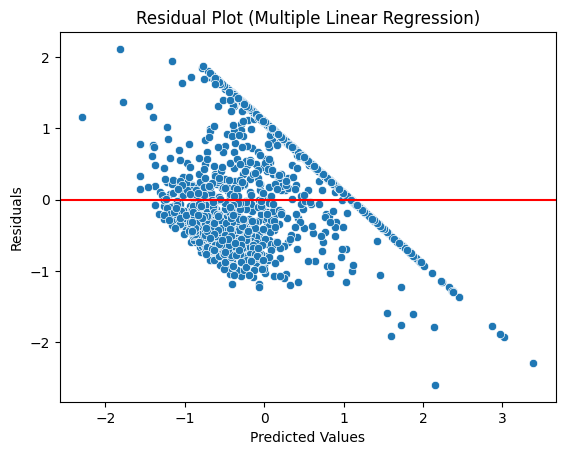

R-squared value:  0.5334627331690129
MSE:  0.474449849105223


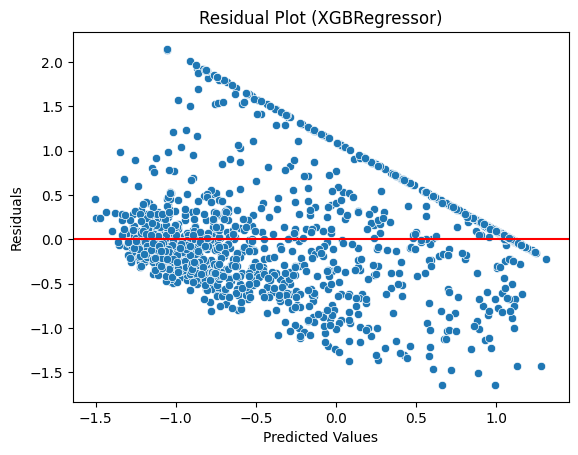

R-squared value:  0.7407441882090212
MSE:  0.26365285161333685


In [35]:
# Create residual plot
residuals = y_test - predictions_MLR
sns.scatterplot(x=predictions_MLR, y=residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot (Multiple Linear Regression)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Quantify model performance
r2 = r2_score(y_test, predictions_MLR)
print("R-squared value: ", r2)
mse = mean_squared_error(y_test, predictions_MLR)
print("MSE: ", mse)

# Create residual plot
residuals = y_test - predictions_XGB
sns.scatterplot(x=predictions_XGB, y=residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot (XGBRegressor)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Quantify model performance
r2 = r2_score(y_test, predictions_XGB)
print("R-squared value: ", r2)
mse = mean_squared_error(y_test, predictions_XGB)
print("MSE: ", mse)


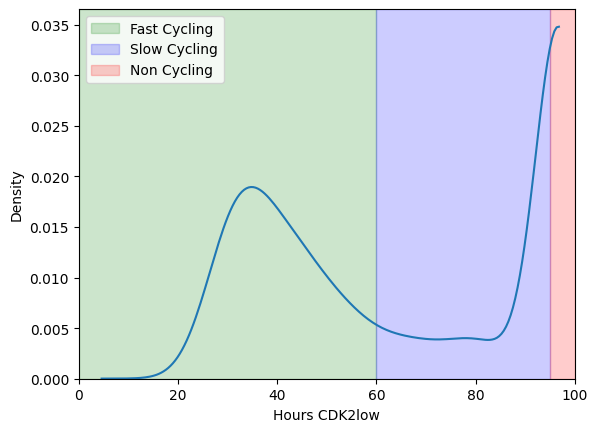

In [74]:
## Based on the residual plots, there is clearly underlying trends in the data not accounted for even by the XGBoost regressor. 
## The obvious linearity in the residuals plot may refer to the stack up of values at the maximum observation for our predictor term (total duration non-cycling throughout live-cell imaging).
## To generate a stronger model, we can implement a XGB Classifier for cell states we annotate based on the CDK2low duration throughout imaging

# Generate cell-cycle annotations based on CDK2low duration
sen = np.array(df.iloc[:, Rterm]) # non normalized state to color
sen = sen/5 # normalized to framerate of movie to yield hours
sns.kdeplot(sen,cut=0)
plt.xlabel('Hours CDK2low')
plt.axvspan(0, 60, alpha=0.2, color='green', label='Fast Cycling')
plt.axvspan(60, 95, alpha=0.2, color='blue', label='Slow Cycling')
plt.axvspan(95, 100, alpha=0.2, color='red', label='Non Cycling')
plt.legend()
plt.xlim(0, 100)

# Generate response classifications based on our cell-cycle annotations
r_class = []
for s in sen:
    if s > 0 and s < 60:
        r_class.append(0) # 0 = Fast
    elif s >= 60 and s < 95:
        r_class.append(1) # 1 = Slow
    elif s >= 95:
        r_class.append(2) # 2 = NC
#print(r_class) # These annotations are what we will use for training our XGBClassifier

In [69]:
# Create XGBClassifier object for multi-class classification
model = XGBClassifier(objective='multi:softmax', num_class=3)

# Split data into 80% training and 20% prediction
X_train, X_test, y_train, y_test = train_test_split(predictor, r_class, test_size=0.2)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions= model.predict(X_test)

# Evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0)) # Percentage of test data correctly classified

Accuracy: 83.13%


In [73]:
## Breaking our analysis down into a simple classification problem allows us to correctly classify cells as fast, slow, or non-cycling from 6 predictor terms
## Will the model perform better if we further simply our case? What if we combine fast and slow and attempt to detect continuously non-cycling instead?

# Binarize data
binary = []
for i in r_class:
    if r_class[i] < 2:
        binary.append(0)
    elif r_class[i] == 2:
        binary.append(1)

# Create XGBClassifier object for multi-class classification
model = XGBClassifier(objective='multi:softmax', num_class=2)

# Split data into 80% training and 20% prediction
X_train, X_test, y_train, y_test = train_test_split(predictor, binary, test_size=0.2)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions= model.predict(X_test)

# Evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0)) # Percentage of test data correctly classified

Accuracy: 89.06%


In [55]:
# Define input data for UMAP
X = df_scaled
sen = np.array(df.iloc[:, Rterm]) # non normalized state to color
sen = sen/5 # normalized to framerate of movie to yield hours

# Perform dimensionality reduction with UMAP
reducer = umap.UMAP(n_components=2, random_state=None)
embedding = reducer.fit_transform(X)

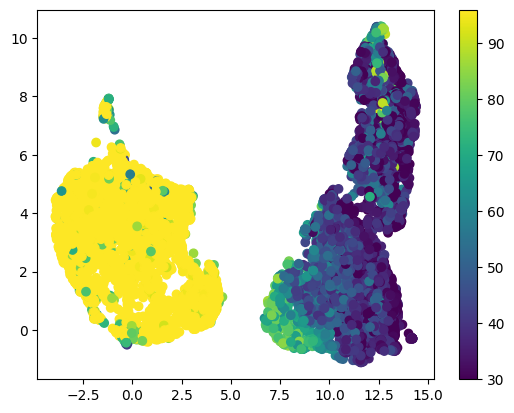

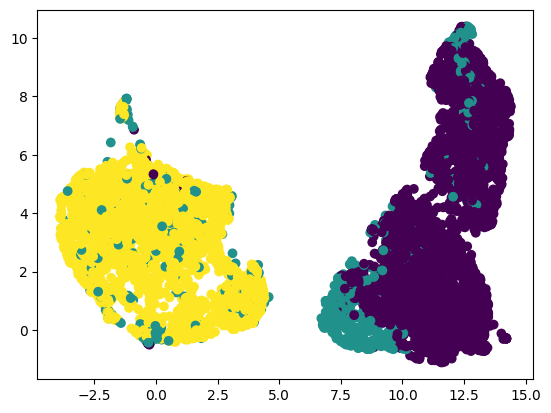

In [56]:
# Visualize the results
# Color the UMAP based on duration withdrawn during imaging
plt.scatter(embedding[:, 0], embedding[:, 1], c=sen) # color dots based on duration withdrawn from cell cycle during movie
plt.colorbar()
plt.clim(30, 96)
plt.show()

# Color the UMAP based on our r_class we defined earlier 
plt.scatter(embedding[:, 0], embedding[:, 1], c=r_class) # (yellow = noncycling; green = slowcycling; blue = fastcycling)
plt.show()

In [57]:
# Apply PHATE for dimensionality reduction
# doi: 10.1038/s41587-019-0336-3
import phate
phate_operator = phate.PHATE(n_jobs=-2)
Y_phate = phate_operator.fit_transform(X)

Calculating PHATE...
  Running PHATE on 8180 observations and 7 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.78 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.82 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.47 seconds.
    Calculating KMeans...
    Calculated KMeans in 2.13 seconds.
  Calculated landmark operator in 3.14 seconds.
  Calculating optimal t...
    Automatically selected t = 47
  Calculated optimal t in 2.15 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.63 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.99 seconds.
Calculated PHATE in 9.73 seconds.


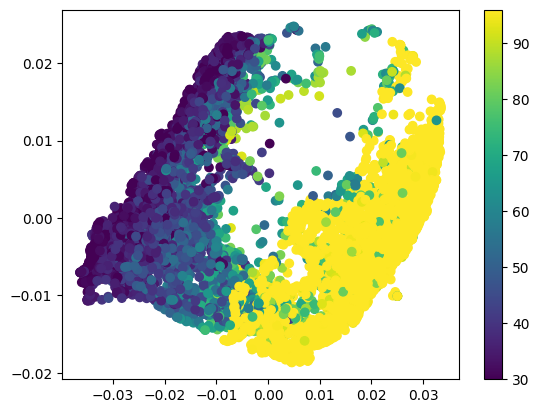

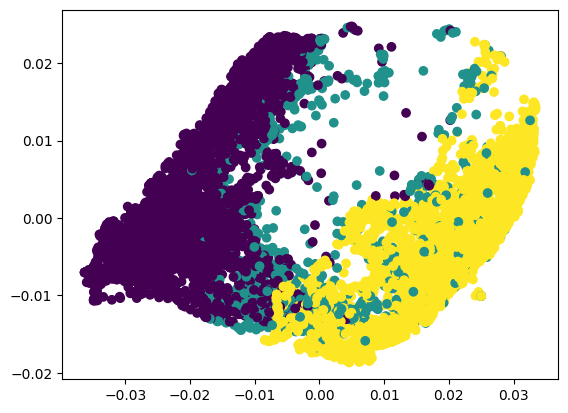

In [58]:
# Visualize the results
# Color the PHATE plot based on duration withdrawn during imaging
plt.scatter(Y_phate[:, 0], Y_phate[:, 1], c=sen) # color dots based on duration withdrawn from cell cycle during movie
plt.colorbar()
plt.clim(30, 96)
plt.show()

# Color the PHATE plot based on our r_class we defined earlier 
plt.scatter(Y_phate[:, 0], Y_phate[:, 1], c=r_class) # (yellow = noncycling; green = slowcycling; blue = fastcycling)
plt.show()